# ML-Modelle auf den Loy & Hutz Ticketdaten entwickeln und evaluieren (Grafiken erstellen)

### Benötigte Pakete importieren und Einstellungen setzen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import os
import time
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Bereinigte Ticketdaten einlesen und Informationen einsehen

In [3]:
ticket_df = pd.read_excel('tickets_cleaned.xlsx')
ticket_df.head(5)

,Unnamed: 0,Ticket-ID,Datum,Stichwort,Meldung,Ticketart,Sprache,Stichwort_cleaned,Meldung_cleaned,Meldung_BERT,Länge,Stichwort_lemmatized,Meldung_lemmatized,Klasse
0,0,TN-2302-00013,2023-02-01 00:00:00,[Ext.] #207695: Wave sehr langsam: Einzelfall?,"Hallo Herr Willi, _x000D__x000D_wir bekommen v...",Support,de,Ext Wave langsam Einzelfall,Hallo Herr Willi bekommen Kollegen beinahe tae...,Hallo Herr Willi wir bekommen von einem Kolleg...,136,Ext Wave langsam Einzelfall,Hallo Herr Willi bekommen Kollege beinahe taeg...,2
1,1,TN-2302-00016,2023-02-01 00:00:00,Per E-Mail senden: license.lhlic,könnt Ihr bitte meine deltaCAD-Demodatenbank-...,Lizenz,de,Per Mail senden license lhlic,koennt Ihr bitte deltaCAD Demodatenbank Lizenz...,koennt Ihr bitte meine deltaCAD Demodatenbank ...,10,per Mail send license Lhlic,koennen ihr bitte deltaCAD Demodatenbank Lizen...,4
2,2,TN-2302-00017,2023-02-01 00:00:00,Bestellung eines Headsets,"Hallo Zusammen,_x000D_\n_x000D_\nich habe aktu...",IT,de,Bestellung Headsets,Hallo Zusammen aktuell probleme Senheiser Head...,Hallo Zusammen ich habe aktuell probleme mit m...,44,Bestellung Headset,Hallo zusammen aktuell problem Senheiser Heads...,3
3,3,TN-2302-00018,2023-02-01 00:00:00,Online Package Repo - Changelog und Release Datum,Im Package Repo fehlt leider die Möglichkeit d...,Wunsch,de,Online Package Repo Changelog Release Datum,Im Package Repo fehlt leider Moeglichkeit dire...,Im Package Repo fehlt leider die Moeglichkeit ...,78,Online Package Repo Changelog Release Datum,in Package Repo fehlen leider Moeglichkeit dir...,1
4,4,TN-2302-00021,2023-02-01 00:00:00,Waveabsturz: Message => Object reference not s...,Wenn man auf einer Tätigkeit steht und auf die...,Bug,de,Waveabsturz Message Object reference not set t...,Wenn Taetigkeit steht neue Funktion Vorgaenge ...,Wenn man auf einer Taetigkeit steht und auf di...,31,Waveabsturz Message Object reference not set t...,wenn Taetigkeit stehen neu Funktion Vorgaeng k...,0


In [4]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43447 entries, 0 to 43446
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            43447 non-null  int64 
 1   Ticket-ID             43447 non-null  object
 2   Datum                 43447 non-null  object
 3   Stichwort             43447 non-null  object
 4   Meldung               43446 non-null  object
 5   Ticketart             43447 non-null  object
 6   Sprache               43447 non-null  object
 7   Stichwort_cleaned     43300 non-null  object
 8   Meldung_cleaned       43447 non-null  object
 9   Meldung_BERT          43447 non-null  object
 10  Länge                 43447 non-null  int64 
 11  Stichwort_lemmatized  43300 non-null  object
 12  Meldung_lemmatized    43447 non-null  object
 13  Klasse                43447 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 4.6+ MB


### Initialisierung der Listen, in denen die Werte gespeichert werden

In [5]:
training_times1 = []

accuracies1 = []

balanced_accuracies = []
balanced_accuracies_ros = []
balanced_accuracies_smote = []

f1_scores_macro1 = []
f1_scores_weighted1 = []

### Baseline-Modell entwickeln, Vorhersagen treffen und Evaluierungswerte in Listen aufnehmen (auf den unbearbeiteten Ticketmeldungen)

In [6]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(ticket_df['Meldung'], ticket_df['Klasse'], random_state = 24)

In [7]:
count_vect_baseline = CountVectorizer()
X_train_counts_baseline = count_vect_baseline.fit_transform(X_train_baseline.values.astype('U'))
X_test_counts_baseline = count_vect_baseline.transform(X_test_baseline.values.astype('U'))

In [8]:
tfidf_transformer_baseline = TfidfTransformer()
X_train_tfidf_baseline = tfidf_transformer_baseline.fit_transform(X_train_counts_baseline)
X_test_tfidf_baseline = tfidf_transformer_baseline.transform(X_test_counts_baseline)

In [9]:
start_time_baseline = time.time()
ticket_clf_baseline = MultinomialNB().fit(X_train_tfidf_baseline, y_train_baseline)
end_time_baseline = time.time()
training_time_baseline = round(end_time_baseline - start_time_baseline, 2)

In [10]:
y_pred_baseline = ticket_clf_baseline.predict(X_test_tfidf_baseline)

In [11]:
print(training_time_baseline)
training_times1.append(training_time_baseline)

accuracy_baseline = round(accuracy_score(y_test_baseline, y_pred_baseline), 2)
print(accuracy_baseline)
accuracies1.append(accuracy_baseline)

balanced_accuracy_baseline = round(balanced_accuracy_score(y_test_baseline, y_pred_baseline), 2)
print(balanced_accuracy_baseline)
balanced_accuracies.append(balanced_accuracy_baseline)

f1_score_macro_baseline = round(f1_score(y_test_baseline, y_pred_baseline, average='macro'), 2)
print(f1_score_macro_baseline)
f1_scores_macro1.append(f1_score_macro_baseline)

f1_score_weighted_baseline = round(f1_score(y_test_baseline, y_pred_baseline, average='weighted'), 2)
print(f1_score_weighted_baseline)
f1_scores_weighted1.append(f1_score_weighted_baseline)

0.04
0.65
0.52
0.54
0.6


### Textrepräsentation durch TF-IDF und Merkmalsauswahl mit Chi-Quadrat-Methode

In [12]:
tfidf = TfidfVectorizer(lowercase=False, analyzer='word', sublinear_tf=True, min_df=2, norm='l2', ngram_range=(1, 3))
features = tfidf.fit_transform(ticket_df['Meldung_lemmatized'].values.astype('U'))
labels = ticket_df.Klasse

In [13]:
tickettype_keys = ['Bug', 'Wunsch', 'Support', 'IT', 'Lizenz', 'Sonstiges']
tickettype_ids = [0, 1, 2, 3, 4, 5]
tickettype_dict = {tickettype_keys[i]: tickettype_ids[i] for i in range(len(tickettype_keys))}

N = 10
for tickettype_key, tickettype_id in sorted(tickettype_dict.items()):
    chi2_features = chi2(features, labels == tickettype_id)
    indices = np.argsort(chi2_features[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\033[1mTicketart {}:\033[0m".format(tickettype_key))
    print("Unigramme mit stärkster Korrelation:\n {}".format(', '.join(unigrams[-N:])))
    print("\n")
    print("Bigramme mit stärkster Korrelation:\n {}".format(', '.join(bigrams[-N:])))
    print("\n---\n")

Ticketart Bug:
Unigramme mit stärkster Korrelation:
 Screenshot, Software, Lizenz, Danke, Backup, sehen, Fehler, bitte, DMS, Loyhutz


Bigramme mit stärkster Korrelation:
 Jahr Newsletter, Dienstleistung angegeben, Adresse zusenden, Information Software, Ja willig, Datum verarbeiten, vorgenannt Datum, Zweck vorgenannt, sehen DMS, Loyhutz Loyhutz

---

Ticketart IT:
Unigramme mit stärkster Korrelation:
 Hannes, Systemberater, ThomasWilli, SeniorProjectManager, IT, Gregor, Projektmanagement, Pflichtangaben, gesetzlich, Loyhutz


Bigramme mit stärkster Korrelation:
 Hi IT, Willi Loyhutz, ThomasWilli SeniorProjectManager, Thomas ThomasWilli, SeniorProjectManager Thomas, Hallo Gregor, Hallo IT, gesetzlich Pflichtangaben, Loyhutz gesetzlich, Loyhutz Loyhutz

---

Ticketart Lizenz:
Unigramme mit stärkster Korrelation:
 erweitern, netzen, ART, zentral, Kopie, bw, Zentrale, verlaengern, Lizenz, Ext


Bigramme mit stärkster Korrelation:
 Danke Bernd, Moin zusammen, zentral Loyhutz, bw Gesendet, 

### Train/Test Split und Resampling der Trainings- und Testdaten

In [14]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, ticket_df.index, test_size=0.2, stratify=labels, random_state=24)

In [15]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=24)
smote = SMOTE(random_state=24, k_neighbors=5)

In [16]:
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### MNB-Modell entwickeln, Vorhersagen treffen und Evaluierungswerte in Listen aufnehmen (ohne Resampling)

In [17]:
param_grid = {'alpha': [0.1, 0.4, 0.7, 1], 'fit_prior': [True, False]}
grid_clf = GridSearchCV(MultinomialNB(), param_grid)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_estimator_)
grid_clf_predict = grid_clf.predict(X_test)
print(accuracy_score(y_test, grid_clf_predict))

MultinomialNB(alpha=0.1, fit_prior=False)
0.7243958573072498


In [18]:
start_time_mnb = time.time()
ticket_clf_mnb = MultinomialNB(alpha=0.1, fit_prior=False).fit(X_train, y_train)
end_time_mnb = time.time()
training_time_mnb = round(end_time_mnb - start_time_mnb, 2)

In [19]:
y_pred_mnb = ticket_clf_mnb.predict(X_test)

In [20]:
print(training_time_mnb)
training_times1.append(training_time_mnb)

accuracy_mnb = round(accuracy_score(y_test, y_pred_mnb), 2)
print(accuracy_mnb)
accuracies1.append(accuracy_mnb)

balanced_accuracy_mnb = round(balanced_accuracy_score(y_test, y_pred_mnb), 2)
print(balanced_accuracy_mnb)
balanced_accuracies.append(balanced_accuracy_mnb)

f1_score_macro_mnb = round(f1_score(y_test, y_pred_mnb, average='macro'), 2)
print(f1_score_macro_mnb)
f1_scores_macro1.append(f1_score_macro_mnb)

f1_score_weighted_mnb = round(f1_score(y_test, y_pred_mnb, average='weighted'), 2)
print(f1_score_weighted_mnb)
f1_scores_weighted1.append(f1_score_weighted_mnb)

0.07
0.72
0.73
0.74
0.72


### MNB-Modell mit ROS-Resampling

In [21]:
start_time_mnb_ros = time.time()
ticket_clf_mnb_ros = MultinomialNB(alpha=0.1, fit_prior=False).fit(X_train_ros, y_train_ros)
end_time_mnb_ros = time.time()
training_time_mnb_ros = round(end_time_mnb_ros - start_time_mnb_ros, 2)

In [22]:
y_pred_mnb_ros = ticket_clf_mnb_ros.predict(X_test)

In [23]:
print(training_time_mnb_ros)

accuracy_mnb_ros = round(accuracy_score(y_test, y_pred_mnb_ros), 2)
print(accuracy_mnb_ros)

balanced_accuracy_mnb_ros = round(balanced_accuracy_score(y_test, y_pred_mnb_ros), 2)
print(balanced_accuracy_mnb_ros)

f1_score_macro_mnb_ros = round(f1_score(y_test, y_pred_mnb_ros, average='macro'), 2)
print(f1_score_macro_mnb_ros)

f1_score_weighted_mnb_ros = round(f1_score(y_test, y_pred_mnb_ros, average='weighted'), 2)
print(f1_score_weighted_mnb_ros)

0.1
0.7
0.75
0.71
0.69


### MNB-Modell mit SMOTE-Resampling

In [24]:
start_time_mnb_smote = time.time()
ticket_clf_mnb_smote = MultinomialNB(alpha=0.1, fit_prior=False).fit(X_train_smote, y_train_smote)
end_time_mnb_smote = time.time()
training_time_mnb_smote = round(end_time_mnb_smote - start_time_mnb_smote, 2)

In [25]:
y_pred_mnb_smote = ticket_clf_mnb_smote.predict(X_test)

In [26]:
print(training_time_mnb_smote)

accuracy_mnb_smote = round(accuracy_score(y_test, y_pred_mnb_smote), 2)
print(accuracy_mnb_smote)

balanced_accuracy_mnb_smote = round(balanced_accuracy_score(y_test, y_pred_mnb_smote), 2)
print(balanced_accuracy_mnb_smote)

f1_score_macro_mnb_smote = round(f1_score(y_test, y_pred_mnb_smote, average='macro'), 2)
print(f1_score_macro_mnb_smote)

f1_score_weighted_mnb_smote = round(f1_score(y_test, y_pred_mnb_smote, average='weighted'), 2)
print(f1_score_weighted_mnb_smote)

0.12
0.71
0.74
0.71
0.7


### SVM-Modell entwickeln, Vorhersagen treffen und Evaluierungswerte in Listen aufnehmen (ohne Resampling)

In [27]:
param_grid = {'C': [0.01, 1, 10, 100], 'max_iter': [1000, 10000, 100000]}
grid_clf = GridSearchCV(LinearSVC(), param_grid)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_estimator_)
grid_clf_predict = grid_clf.predict(X_test)
print(accuracy_score(y_test, grid_clf_predict))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1)
0.7582278481012659


In [28]:
start_time_svm = time.time()
ticket_clf_svm = LinearSVC().fit(X_train, y_train)
end_time_svm = time.time()
training_time_svm = round(end_time_svm - start_time_svm, 2)

In [29]:
y_pred_svm = ticket_clf_svm.predict(X_test)

In [30]:
print(training_time_svm)
training_times1.append(training_time_svm)

accuracy_svm = round(accuracy_score(y_test, y_pred_svm), 2)
print(accuracy_svm)
accuracies1.append(accuracy_svm)

balanced_accuracy_svm = round(balanced_accuracy_score(y_test, y_pred_svm), 2)
print(balanced_accuracy_svm)
balanced_accuracies.append(balanced_accuracy_svm)

f1_score_macro_svm = round(f1_score(y_test, y_pred_svm, average='macro'), 2)
print(f1_score_macro_svm)
f1_scores_macro1.append(f1_score_macro_svm)

f1_score_weighted_svm = round(f1_score(y_test, y_pred_svm, average='weighted'), 2)
print(f1_score_weighted_svm)
f1_scores_weighted1.append(f1_score_weighted_svm)

2.87
0.76
0.74
0.77
0.75


### SVM-Modell mit ROS-Resampling

In [31]:
start_time_svm_ros = time.time()
ticket_clf_svm_ros = LinearSVC(class_weight='balanced').fit(X_train_ros, y_train_ros)
end_time_svm_ros = time.time()
training_time_svm_ros = round(end_time_svm_ros - start_time_svm_ros, 2)

In [32]:
y_pred_svm_ros = ticket_clf_svm_ros.predict(X_test)

In [33]:
print(training_time_svm_ros)

accuracy_svm_ros = round(accuracy_score(y_test, y_pred_svm_ros), 2)
print(accuracy_svm_ros)

balanced_accuracy_svm_ros = round(balanced_accuracy_score(y_test, y_pred_svm_ros), 2)
print(balanced_accuracy_svm_ros)

f1_score_macro_svm_ros = round(f1_score(y_test, y_pred_svm_ros, average='macro'), 2)
print(f1_score_macro_svm_ros)

f1_score_weighted_svm_ros = round(f1_score(y_test, y_pred_svm_ros, average='weighted'), 2)
print(f1_score_weighted_svm_ros)

7.0
0.75
0.76
0.77
0.75


### SVM-Modell mit SMOTE-Resampling

In [34]:
start_time_svm_smote = time.time()
ticket_clf_svm_smote = LinearSVC(class_weight='balanced').fit(X_train_smote, y_train_smote)
end_time_svm_smote = time.time()
training_time_svm_smote = round(end_time_svm_smote - start_time_svm_smote, 2)

In [35]:
y_pred_svm_smote = ticket_clf_svm_smote.predict(X_test)

In [36]:
print(training_time_svm_smote)

accuracy_svm_smote = round(accuracy_score(y_test, y_pred_svm_smote), 2)
print(accuracy_svm_smote)

balanced_accuracy_svm_smote = round(balanced_accuracy_score(y_test, y_pred_svm_smote), 2)
print(balanced_accuracy_svm_smote)

f1_score_macro_svm_smote = round(f1_score(y_test, y_pred_svm_smote, average='macro'), 2)
print(f1_score_macro_svm_smote)

f1_score_weighted_svm_smote = round(f1_score(y_test, y_pred_svm_smote, average='weighted'), 2)
print(f1_score_weighted_svm_smote)

7.44
0.75
0.76
0.77
0.75


### BERT-Werte holen

In [37]:
with open('value_cache_bert', 'r') as f:
    json_bert = json.load(f)
    
training_time_bert = json_bert['training_time_bert']
accuracy_bert = json_bert['accuracy_bert']
balanced_accuracy_bert = round(json_bert['balanced_accuracy_bert'], 2)
balanced_accuracy_bert_old = 0.76 # Wert, der vor der Anpassung der Verlustfunktion ermittelt wurde
f1_score_macro_bert = json_bert['f1_score_macro_bert']
f1_score_weighted_bert = json_bert['f1_score_weighted_bert']

In [38]:
training_times1.append(round(training_time_bert, 2))
accuracies1.append(round(accuracy_bert, 2))
balanced_accuracies.append(balanced_accuracy_bert_old)
f1_scores_macro1.append(round(f1_score_macro_bert, 2))
f1_scores_weighted1.append(round(f1_score_weighted_bert, 2))

### Ergebnisse auf dem Vergleichsdatensatz holen

In [39]:
with open('value_cache_finance', 'r') as f:
    json_finance = json.load(f)

accuracies2 = json_finance['accuracies2']
training_times2 = json_finance['training_times2']
f1_scores_macro2 = json_finance['f1_scores_macro2']
f1_scores_weighted2 = json_finance['f1_scores_weighted2']

### Grafik Genauigkeiten

In [40]:
model_names = ['Baseline', 'MNB', 'SVM', 'BERT']

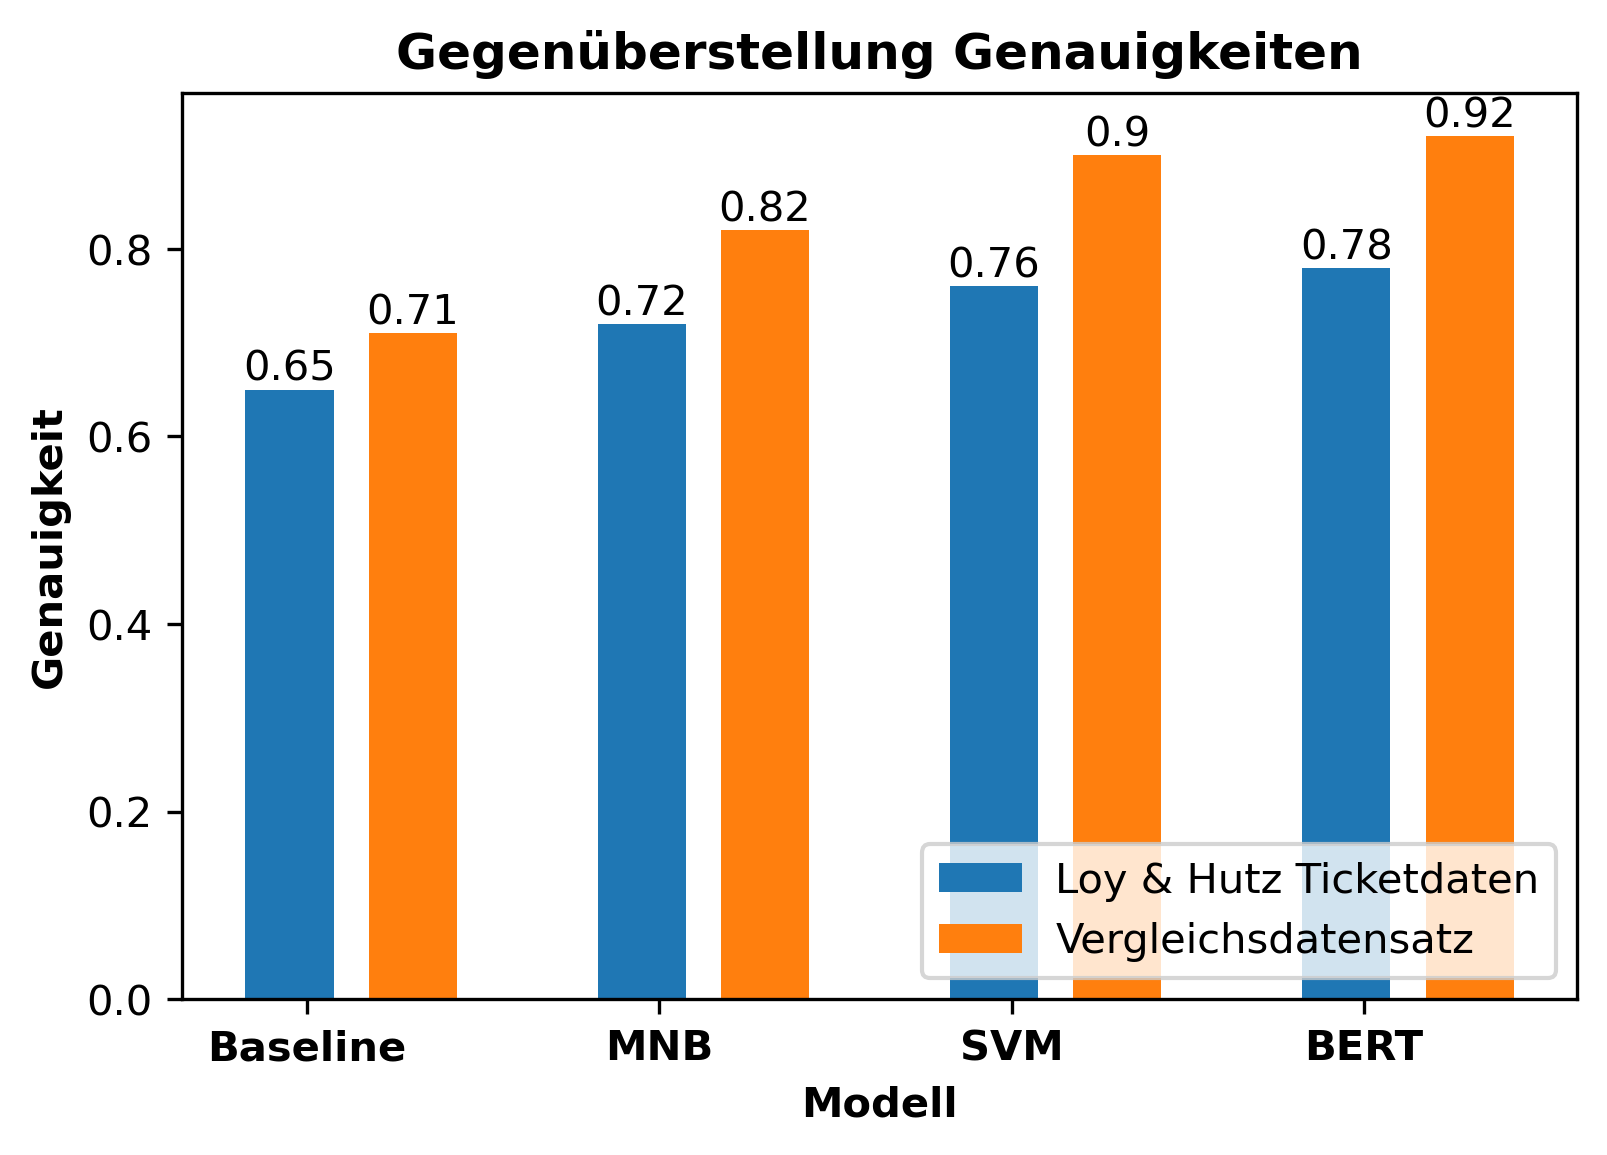

In [41]:
plt.bar([x - 0.175 for x in range(len(accuracies1))], accuracies1, width=0.25, align='edge')
plt.bar([x + 0.175 for x in range(len(accuracies2))], accuracies2, width=0.25, align='edge')

for i in range(len(accuracies1)):
    plt.text(i - 0.175 + 0.125, accuracies1[i] + 0.01, str(accuracies1[i]), ha='center')
    plt.text(i + 0.175 + 0.125, accuracies2[i] + 0.01, str(accuracies2[i]), ha='center')

plt.xlabel('Modell', fontweight='bold')
plt.ylabel('Genauigkeit', fontweight='bold')

plt.xticks(range(len(model_names)), model_names, fontweight='bold')

plt.legend(['Loy & Hutz Ticketdaten', 'Vergleichsdatensatz'], loc='lower right')

plt.title('Gegenüberstellung Genauigkeiten', fontweight='bold')

plt.savefig('pictures/accuracies.png', dpi=600)
plt.show()

### Grafik Genauigkeiten (ausbalanciert)

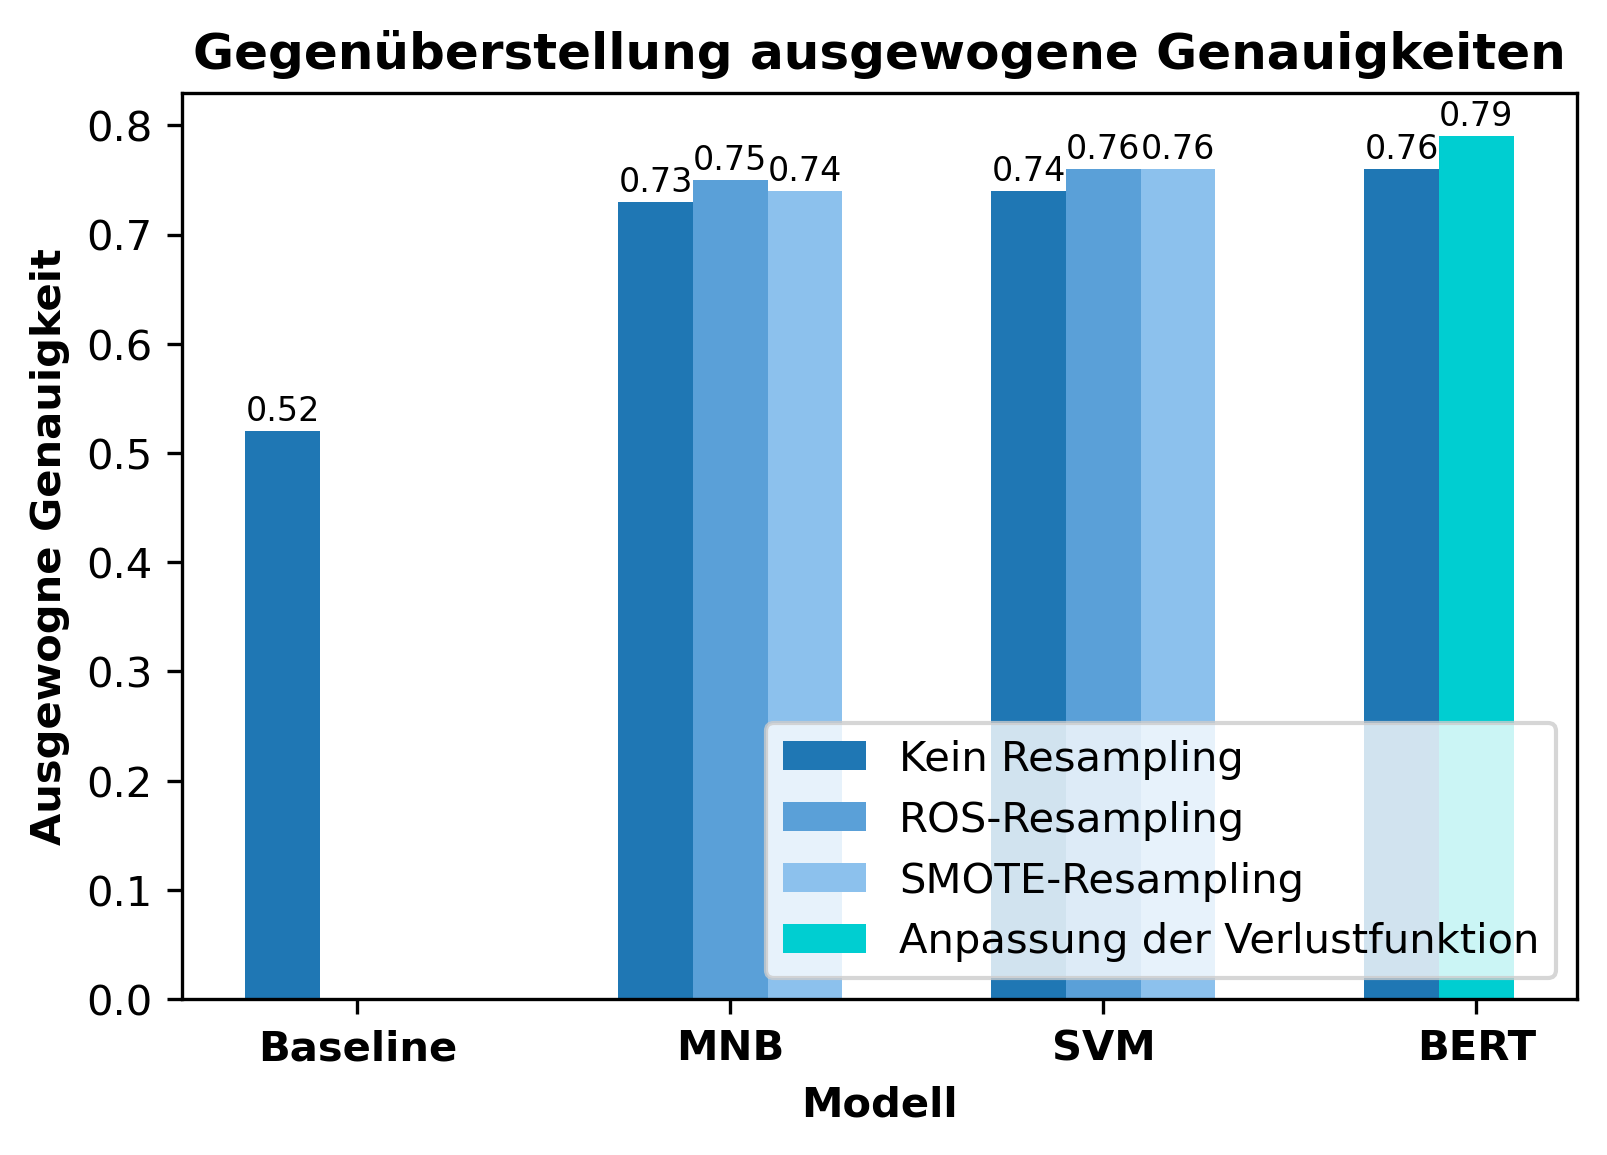

In [42]:
balanced_accuracies_ros = [None, balanced_accuracy_mnb_ros, balanced_accuracy_svm_ros, None]
balanced_accuracies_smote = [None, balanced_accuracy_mnb_smote, balanced_accuracy_svm_smote, None]
balanced_accuracies_new = [None, None, None, balanced_accuracy_bert]

plt.bar([x - 0.3 for x in range(3)] + [2.7], balanced_accuracies[:3] + [balanced_accuracies[3]], width=0.2, color='#1f77b4', align='edge')
plt.bar([x - 0.1 for x in range(1, 3)], balanced_accuracies_ros[1:3], width=0.2, color='#5aa0d8', align='edge')
plt.bar([x + 0.1 for x in range(1, 3)], balanced_accuracies_smote[1:3], width=0.2, color='#8cc1ed', align='edge')
plt.bar(2.9, balanced_accuracies_new[3], width=0.2, color='#00ced1', align='edge')

for i in range(len(balanced_accuracies)):
    plt.text(i - 0.3 + 0.1, balanced_accuracies[i] + 0.01, str(balanced_accuracies[i]), fontsize=8, ha='center', color='black')
    if 0 < i < 3:
        plt.text(i - 0.1 + 0.1, balanced_accuracies_ros[i] + 0.01, str(balanced_accuracies_ros[i]), fontsize=8, ha='center', color='black')
        plt.text(i + 0.1 + 0.1, balanced_accuracies_smote[i] + 0.01, str(balanced_accuracies_smote[i]), fontsize=8, ha='center', color='black')
    elif i == 3:
        plt.text(2.9 + 0.1, balanced_accuracies_new[i] + 0.01, str(balanced_accuracies_new[i]), fontsize=8, ha='center', color='black')

plt.xlabel('Modell', fontweight='bold')
plt.ylabel('Ausgewogne Genauigkeit', fontweight='bold')

plt.title('Gegenüberstellung ausgewogene Genauigkeiten', fontweight='bold')

plt.legend(['Kein Resampling', 'ROS-Resampling', 'SMOTE-Resampling', 'Anpassung der Verlustfunktion'], loc='lower right')

plt.xticks(range(len(model_names)), model_names, fontweight='bold')

plt.savefig('pictures/balanced_accuracies.png', dpi=600)
plt.show()

### Grafik F1-Scores

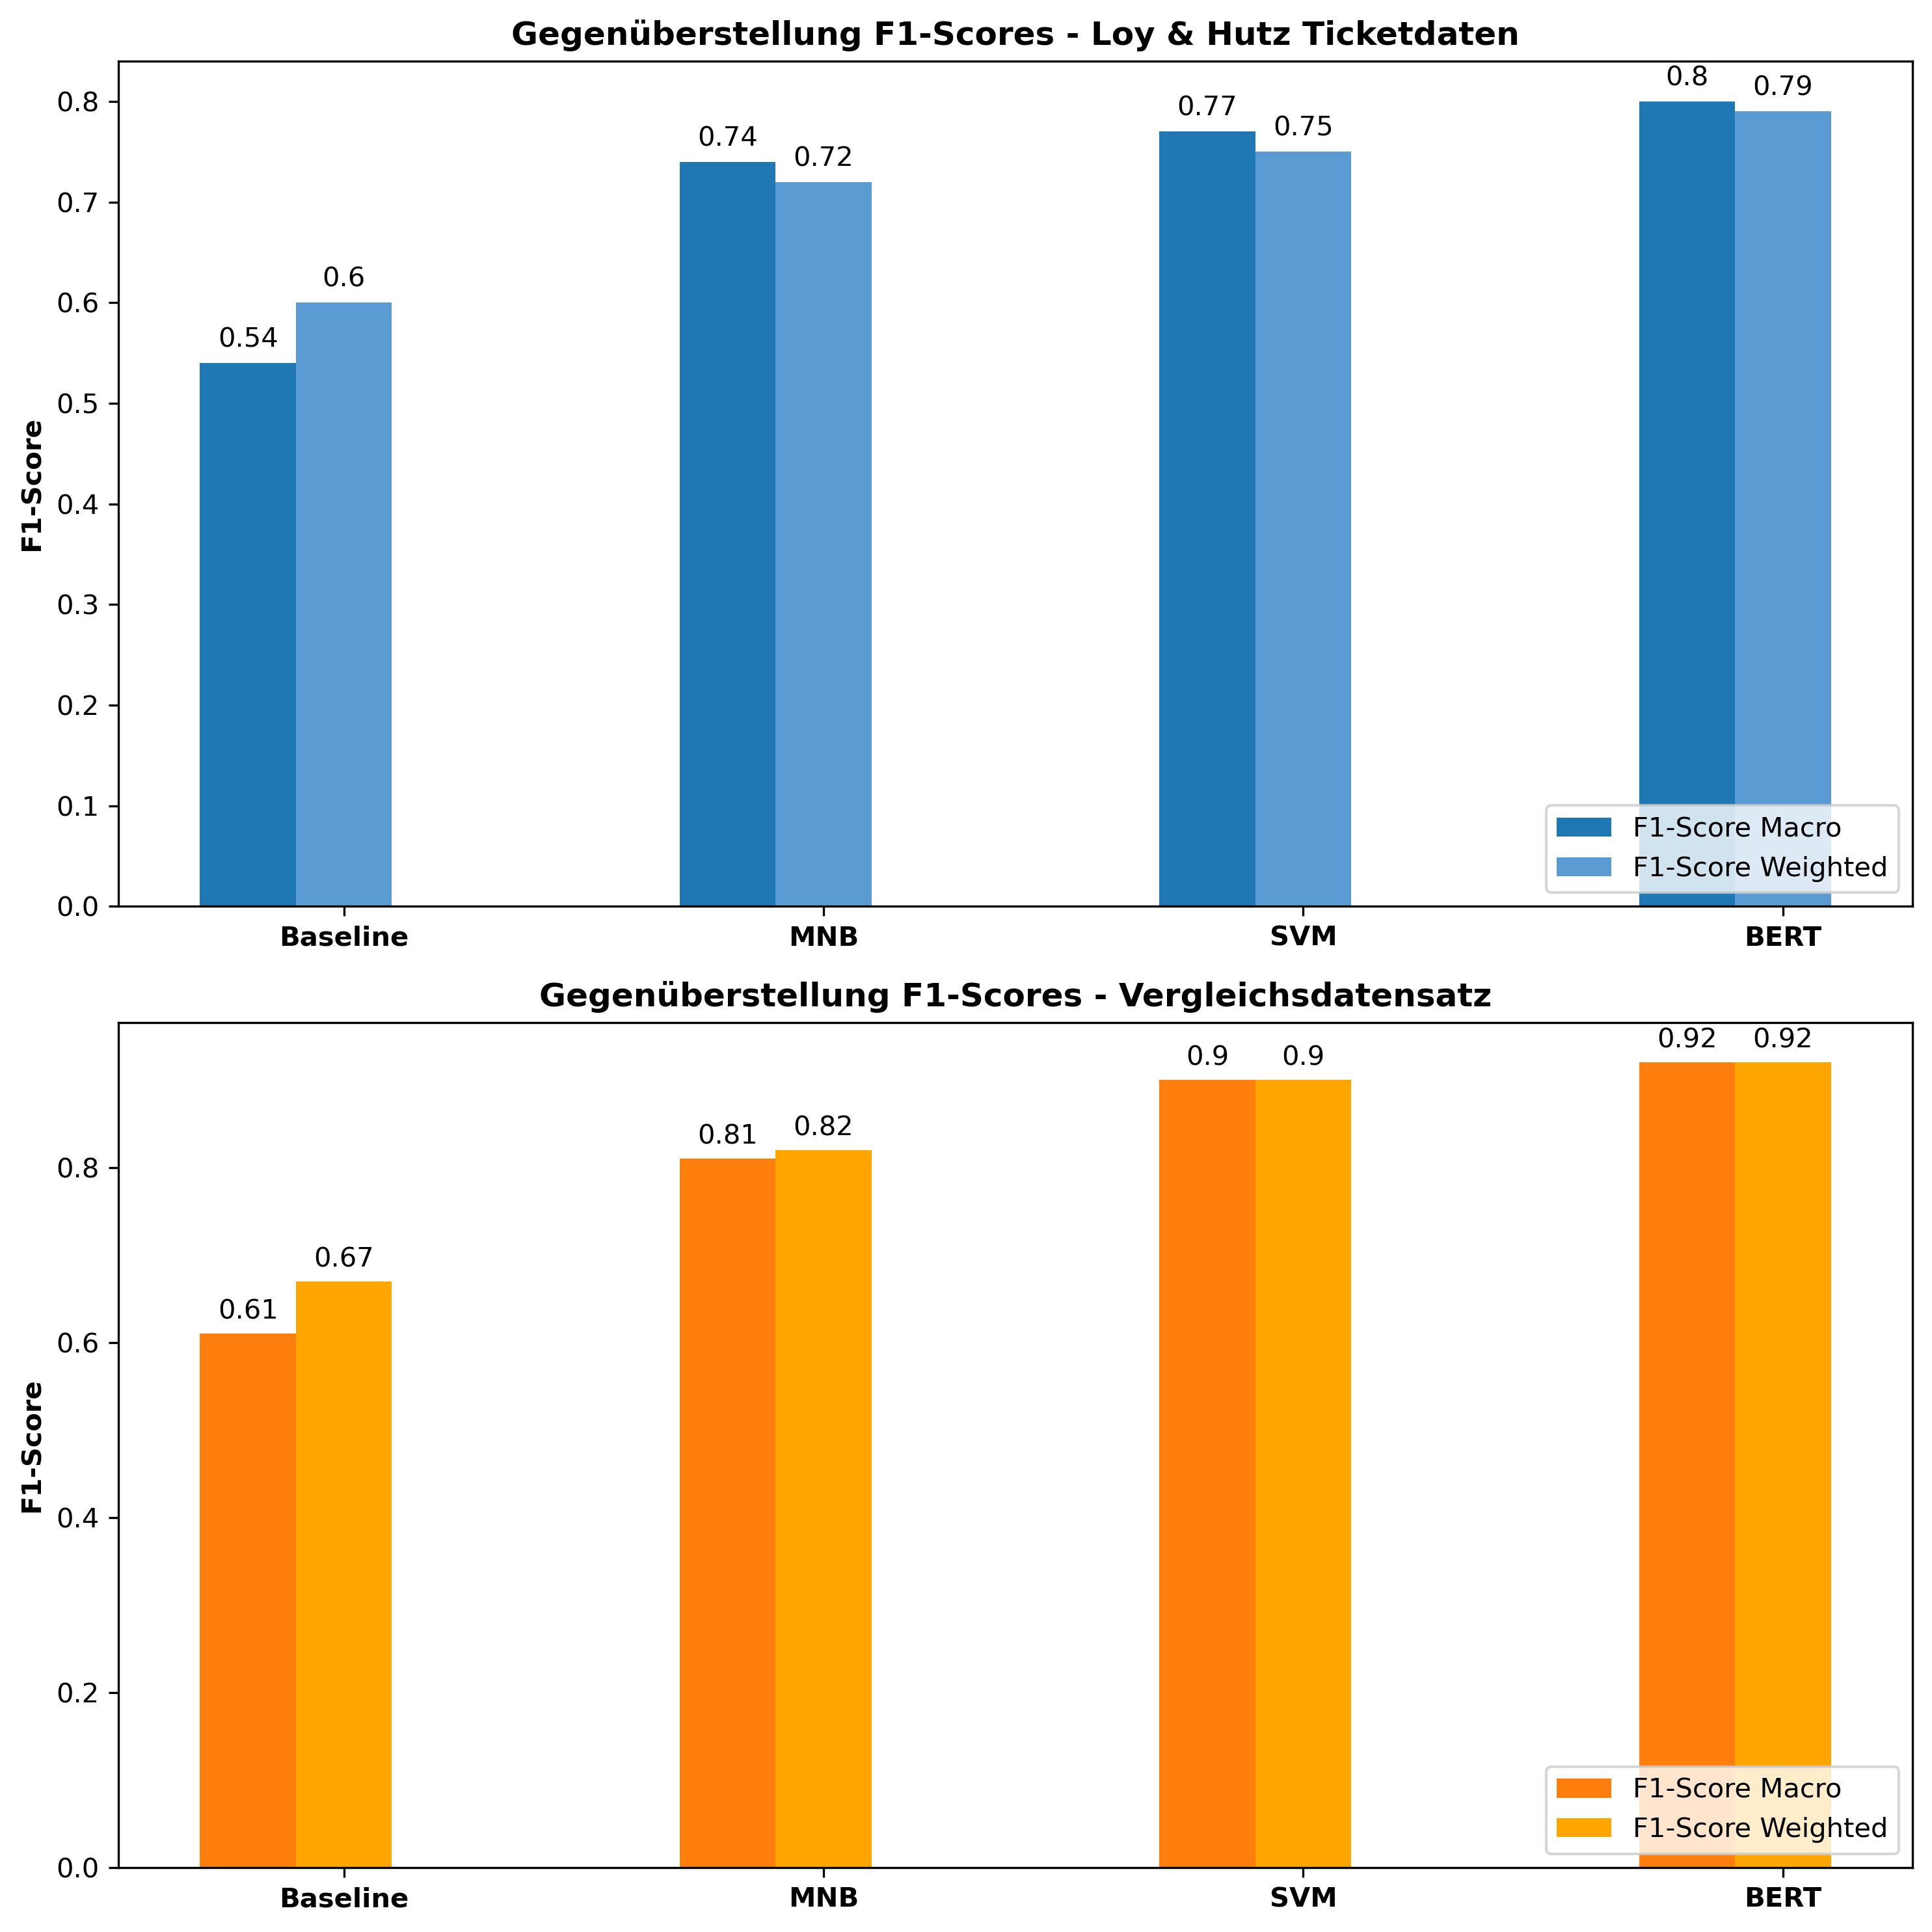

In [43]:
categories = ['F1-Score Macro', 'F1-Score Weighted']

f1_scores_plot1 = np.vstack([f1_scores_macro1, f1_scores_weighted1]).T
f1_scores_plot2 = np.vstack([f1_scores_macro2, f1_scores_weighted2]).T

bar_width = 0.2
n_models = len(model_names)
n_categories = len(categories)

colors_plot1 = ['#1f77b4', '#5a9bd4']
colors_plot2 = ['#ff7f0e', '#ffa500']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x = np.arange(n_models)
for i in range(n_categories):
    ax1.bar(x + i * bar_width, f1_scores_plot1[:, i], width=bar_width, label=categories[i], color=colors_plot1[i])
    for j, v in enumerate(f1_scores_plot1[:, i]):
        ax1.text(j + i * bar_width, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(model_names, fontweight='bold')
ax1.set_ylabel('F1-Score', fontweight='bold')
ax1.set_title('Gegenüberstellung F1-Scores - Loy & Hutz Ticketdaten', fontweight='bold')
ax1.legend(loc='lower right')

x = np.arange(n_models)
for i in range(n_categories):
    ax2.bar(x + i * bar_width, f1_scores_plot2[:, i], width=bar_width, label=categories[i], color=colors_plot2[i])
    for j, v in enumerate(f1_scores_plot2[:, i]):
        ax2.text(j + i * bar_width, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

ax2.set_xticks(x + bar_width)
ax2.set_xticklabels(model_names, fontweight='bold')
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('Gegenüberstellung F1-Scores - Vergleichsdatensatz', fontweight='bold')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('pictures/f1_scores.png', dpi=600)
plt.show()

### Grafik Trainingszeiten

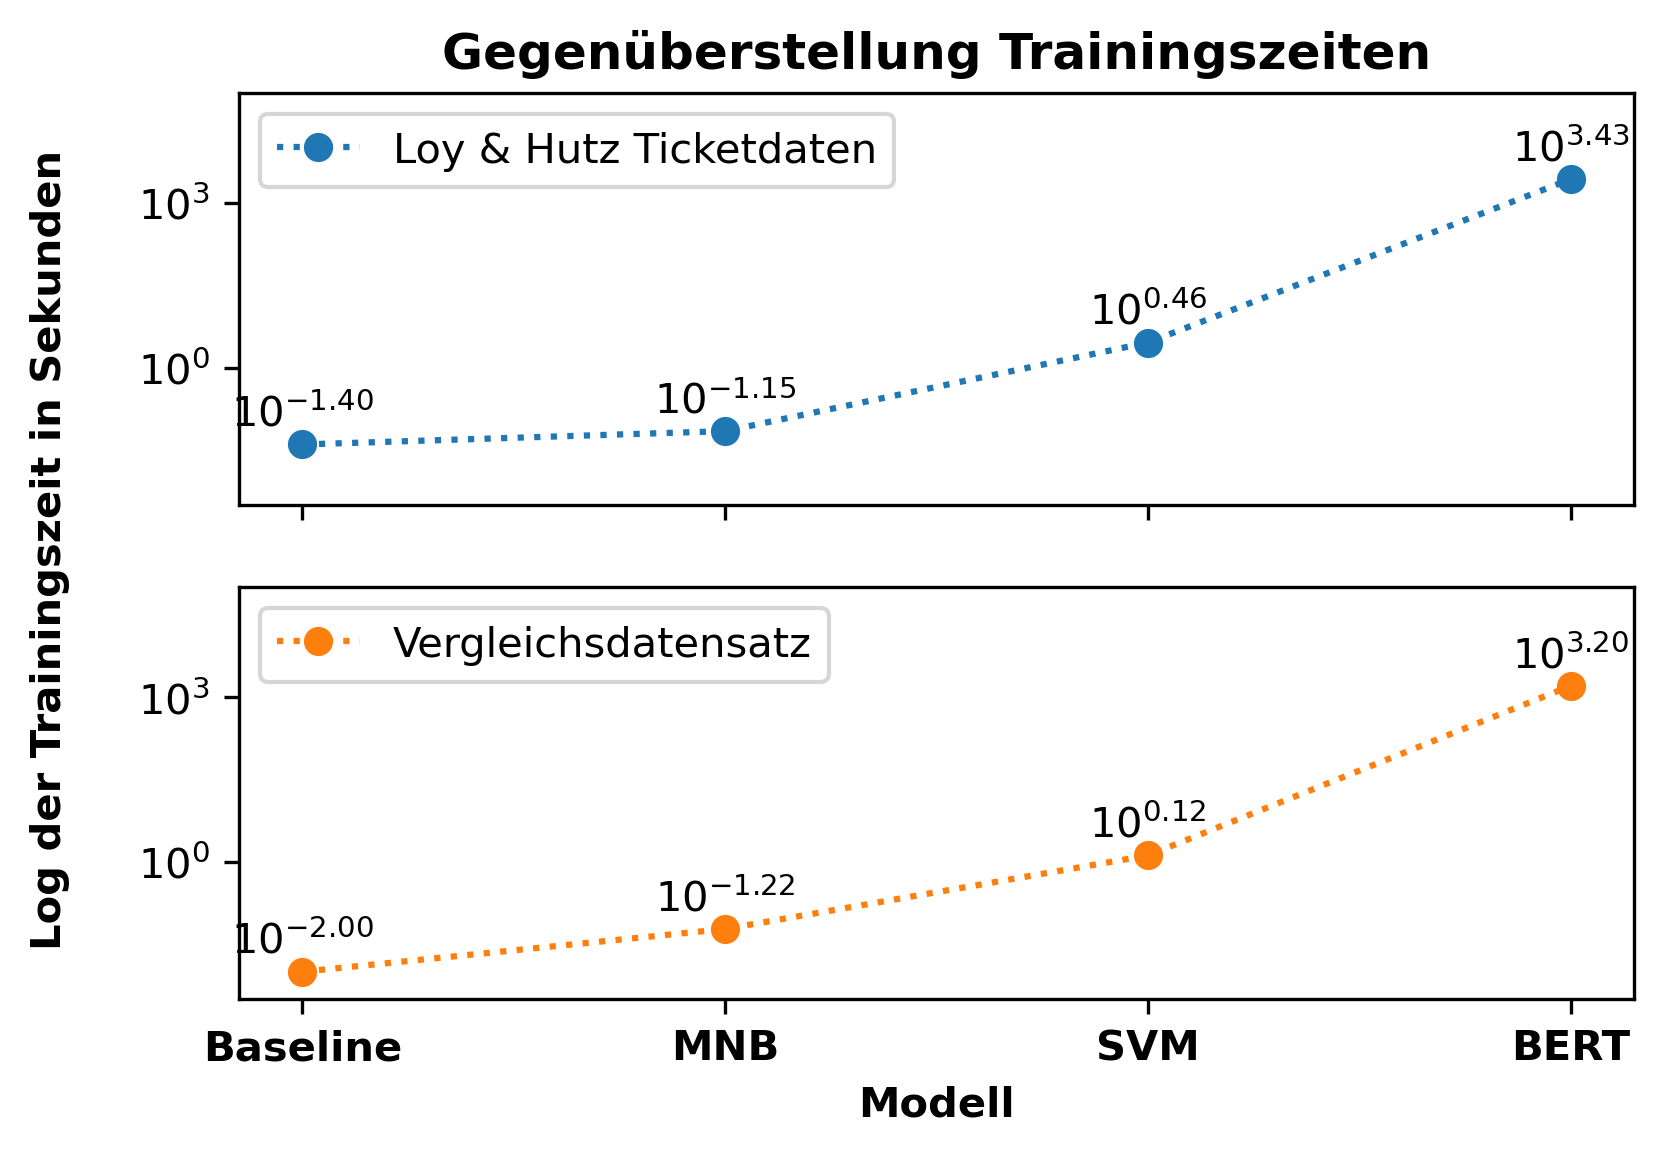

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(training_times1, marker='o', linestyle=':', label='Loy & Hutz Ticketdaten')
ax1.set_title('Gegenüberstellung Trainingszeiten', fontweight='bold')
ax1.set_yscale("log")
ax1.set_ylim([10**(-2.5), 10**5])

fig.text(0.02, 0.5, 'Log der Trainingszeit in Sekunden', ha='center', va='center', rotation='vertical', fontweight='bold')

ax1.set_xticks(range(4))
ax1.set_xticklabels(model_names, fontweight='bold')

for i, time in enumerate(training_times1):
    ax1.text(i, time*1.5, r"$10^{{{:0.2f}}}$".format(np.log10(time)), ha='center', va='bottom')
    
ax1.legend(loc='upper left')    

ax2.plot(training_times2, marker='o', linestyle=':', color='#FF7F0E', label='Vergleichsdatensatz')
ax2.set_xlabel('Modell', fontweight='bold')
ax2.set_yscale("log")
ax2.set_ylim([10**(-2.5), 10**5])

for i, time in enumerate(training_times2):
    ax2.text(i, time*1.5, r"$10^{{{:0.2f}}}$".format(np.log10(time)), ha='center', va='bottom')
    
ax2.legend(loc='upper left')

ax2.set_xticklabels(model_names, fontweight='bold')

plt.savefig('pictures/training_times.png', dpi=600)
plt.show()

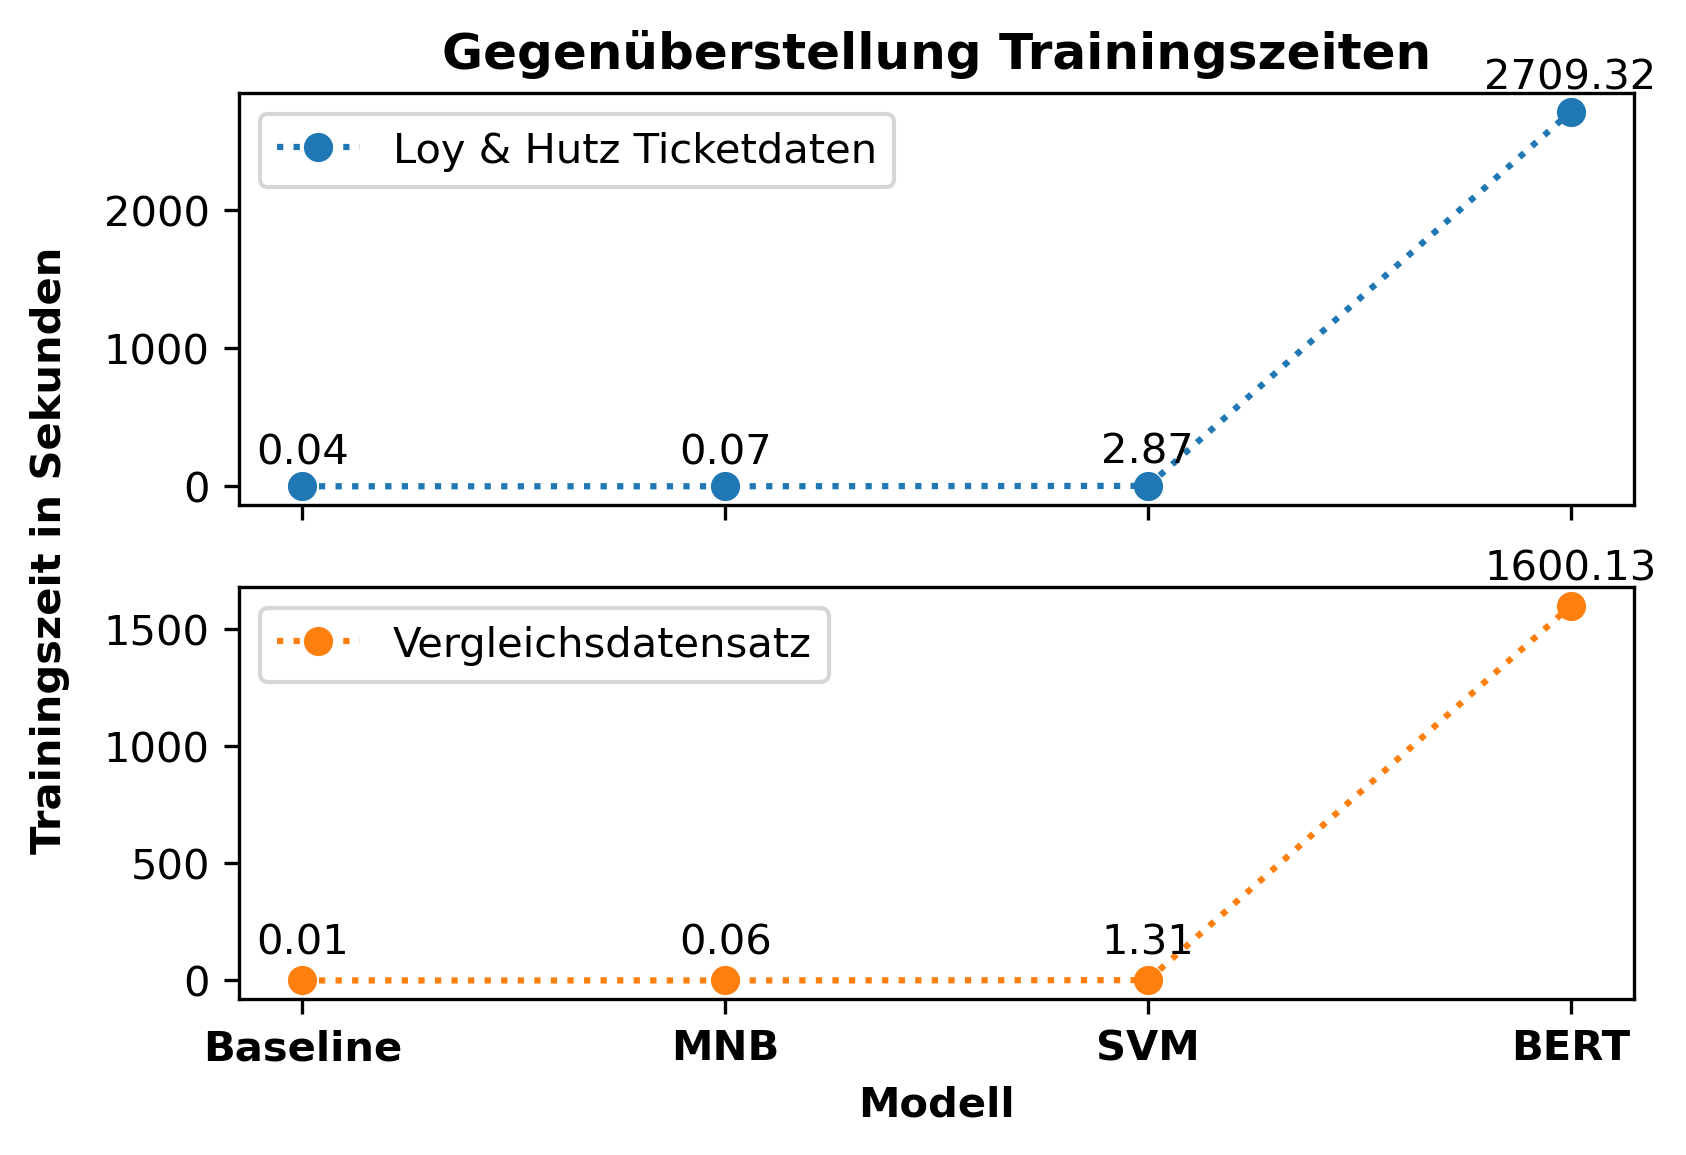

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(training_times1, marker='o', linestyle=':', label='Loy & Hutz Ticketdaten')
ax1.set_title('Gegenüberstellung Trainingszeiten', fontweight='bold')

fig.text(0.02, 0.5, 'Trainingszeit in Sekunden', ha='center', va='center', rotation='vertical', fontweight='bold')

ax1.set_xticks(range(4))
ax1.set_xticklabels(model_names, fontweight='bold')

for i, time in enumerate(training_times1):
    ax1.text(i, time+100, str(time), ha='center', va='bottom')
    
ax1.legend()    

ax2.plot(training_times2, marker='o', linestyle=':', color='#FF7F0E', label='Vergleichsdatensatz')
ax2.set_xlabel('Modell', fontweight='bold')

for i, time in enumerate(training_times2):
    ax2.text(i, time+75, str(time), ha='center', va='bottom')
    
ax2.legend()

ax2.set_xticklabels(model_names, fontweight='bold')

plt.savefig('pictures/training_times.png', dpi=600)
plt.show()

### Falschklassifikationen erkunden

In [46]:
data = {'Ticketart': tickettype_keys,
        'Klasse': tickettype_ids}
class_df = pd.DataFrame(data)

class_to_tickettype = dict(class_df.values)
tickettype_to_class = dict(class_df[['Klasse', 'Ticketart']].values)

conf_mat = confusion_matrix(y_test, y_pred_svm)

In [47]:
for predicted in class_df.Klasse:
    for actual in class_df.Klasse:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(tickettype_to_class[actual], tickettype_to_class[predicted], conf_mat[actual, predicted]))
            display(ticket_df.loc[indices_test[(y_test == actual) & (y_pred_svm == predicted)]][['Ticket-ID', 'Klasse', 'Ticketart', 'Meldung', 'Meldung_lemmatized', 'Länge']])
            print('')

'Wunsch' predicted as 'Bug' : 479 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
42664,TN-1802-00446,1,Wunsch,Hier mein Vorschlagfür die Such- und Anzeigefe...,hier Vorschlagfuer Such Anzeigefelder sehen An...,9
27346,TN-2001-09399,1,Wunsch,1. Fenster für Online-Aktivierung hat verschi...,Fenster Fuer Online Aktivierung verschieden Na...,80
22320,TN-2009-00457,1,Wunsch,Bei der Registrierung im Service Center sollte...,bei Registrierung Service Center sollen mehr H...,52
31925,TN-1907-03047,1,Wunsch,"Sehr geehrter Herr Theresiak, _x000D__x000D_de...",sehr geehrt Herr Theresiak Netevent User melde...,223
17676,TN-2103-01020,1,Wunsch,Nachträgliches Verknüpfen von Bewegungen (Vorg...,Nachtraegliches Verknuepf Bewegung Vorgaenger ...,84
...,...,...,...,...,...,...
19646,TN-2012-09348,1,Wunsch,Bitte eine Serie physisch löschen_x000D_\n_x00...,bitt Serie physisch loesch Hallo Herr Willi kö...,101
39533,TN-1807-00997,1,Wunsch,Bewegung Angebote bei Projekt. Feld Angebotst...,Bewegung Angebot Projekt Feld Angebotstext Lis...,36
17375,TN-2103-01598,1,Wunsch,Der Kunde muss dieses Feld auswählen um speich...,der Kunde Feld auswaehlen speichern koenn dahe...,16
37413,TN-1810-00388,1,Wunsch,Paket 1449 Urlaubs- und Fehlzeitenverwaltung r...,Paket Urlaub Fehlzeitenverwaltung rechnen Elte...,54



'Support' predicted as 'Bug' : 395 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
29332,TN-1911-01541,2,Support,"Sehr geehrter Herr Krainz, _x000D_nach erhalt ...",sehr geehrt Herr Krainz erhalt Zugang Herr Bal...,113
2499,TN-2210-00720,2,Support,"Hallo Lieber Support, _x000D__x000D_Die App, d...",Hallo Lieber Support der App sie zukommen lies...,78
19443,TN-2101-05409,2,Support,Import CSV wie geht das Anlagen und Termine,Import CSV gehen Anlage Termin,8
4497,TN-2208-01186,2,Support,Füllen der FM-Hierarchien_x000D_\nLöschen von ...,Fuelle FM Hierarchien Loesch Datensaetz storni...,10
33619,TN-1904-31386,2,Support,BMW Kundensupport - waveware langsam und Abstü...,BMW Kundensupport wavewaren langsam abstuerz C...,353
...,...,...,...,...,...,...
27639,TN-2001-06739,2,Support,Selektionen für Rollen im SC verfügbar machen.,Selektion fu Rolle SC verfuegbar,7
25624,TN-2004-12106,2,Support,"ich hatte ja den Fehler, das nach dem Mandante...",ja Fehler Mandantenwechsel Datensaetze aufrufb...,77
19464,TN-2101-05306,2,Support,bitte wiederum die Kopie-Lizenz mit der Zeitbe...,bitte wiederum Kopie Lizenz Zeitbeschraenkung ...,24
9625,TN-2201-03644,2,Support,"Hallo, _x000D_bitte das vorhin hochgeladene Ba...",Hallo bitte vorhin hochgeladen Backup Kunde Jo...,56



'IT' predicted as 'Bug' : 45 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
25691,TN-2004-07995,3,IT,"Habt ihr noch eine Webcam, die ich auf den neu...",Habt Webcam neu Monitor stecken Gruss Christia...,37
9208,TN-2202-00621,3,IT,Bitte um Admineingabe zur Installation von Add...,bitt Admineingabe Installation AddIns XML Comp...,12
3191,TN-2209-03878,3,IT,Auf dem Server srv-otc-13-wwt.lhshosting.local...,auf Server srv Otc wwt lhshosting local bitte ...,14
18588,TN-2102-00818,3,IT,Startmenü geht nicht auf_x000D_\neinige Verknü...,Startmenue gehen Verknuepfung gehen mehr zB pn...,13
9856,TN-2201-02525,3,IT,"Im Verlauf ""Anrufsliste"" wird häufig, aber nic...",in Verlauf Anrufsliste haeufig immer Nummer ma...,22
35462,TN-1901-00492,3,IT,Siehe Screenshot. Auch nach einem Neustart von...,sehen Screenshot auch Neustart Windows beheben...,17
11035,TN-2111-07849,3,IT,wie bekommen aktuell immer wieder Die Meldung ...,bekommen aktuell immer der Meldung Datenwelt P...,31
2429,TN-2210-00848,3,IT,R:/Transfer LHN nicht erreichbar,R Transfer LHN erreichbar,5
42064,TN-1803-00304,3,IT,Beim Systemstart gibt es Fehlermelduungen von ...,bei Systemstart geben Fehlermelduung MSCERTUTI...,8
30214,TN-1909-07801,3,IT,Meine RDP-Verbindung ist immer mal wieder spor...,mein RDP Verbindung immer mal sporadisch fu Mi...,54



'Sonstiges' predicted as 'Bug' : 44 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
5366,TN-2206-13568,5,Auftrag,Die Eingabe von Tags im Ticketassist ist gewün...,der Eingabe Tags Ticketassist wuenschn da aktu...,103
3542,TN-2209-03420,5,Auftrag,Bei der Validierung und Speichern-Button könne...,bei Validierung Speichern Button koenn Screens...,18
2631,TN-2210-00556,5,Sonstiges,MUI Premium für das WebDM installieren,MUI Premium fuer WebDM installieren,6
41402,TN-1804-00528,5,Vertrieb,_x000D_\nErfassen und Verwalten der IT Hardwar...,erfasser Verwalt IT Hardware unabhaengig IT Ab...,29
32887,TN-1905-02907,5,Sonstiges,Update der Datev Version auf die neuste Freiga...,Update Datev Version neuste Freigabe Grund fu ...,17
2324,TN-2210-01026,5,Auftrag,"Es passiert mir öfters, dass ich in das Feld ""...",es passieren oefter Feld Suche klicken moecht ...,131
3517,TN-2209-03388,5,Auftrag,Es gibt eine neue Funktion für die Selektionen...,es geben neu Funktion fu Selektion Datensaetz ...,113
5093,TN-2207-04558,5,Auftrag,Kunde: Hochschule Karlsruhe_x000D_\nVorgehen:_...,Kunde Hochschule Karlsruhe vorgehen Ticketuebe...,84
899,TN-2212-00767,5,Sonstiges,Im Paket 1837 fehlt bei der Installation die A...,in Paket fehlen Installation Auswahlverknuepfu...,22
5759,TN-2206-06954,5,Auftrag,z.B. über einen Button wie bei:_x000D_\nDesign...,z ueber Button Designer Ansicht Karte Reihenfo...,53



'Bug' predicted as 'Wunsch' : 200 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
21202,TN-2010-01050,0,Bug,"Wenn Artikel im QPRO geändert werden, wird die...",wenn Artikel QPRO aendern Lizenz uebernomm Art...,85
42199,TN-1803-00080,0,Bug,Es gibt die Möglichkeit in einer Prüfvorschrif...,es geben Moeglichkeit Pruefvorschrift Pruefvor...,17
7816,TN-2203-04434,0,Bug,"Das Feld ""Behoben ab"" fehlt auf der Ticket-Kar...",der Feld behoben ab fehlen Ticket Karte obwohl...,45
21817,TN-2010-00023,0,Bug,Abweichungen Webclient vs. Fatclient_x000D__x0...,Abweichung Webclient vs FatclientNur Webclient...,55
117,TN-2301-00922,0,Bug,DGN-Import startet nicht mehr,DGN Import starten mehr,5
...,...,...,...,...,...,...
34752,TN-1902-01289,0,Bug,"Wenn Passwort die Komplexität nicht erfüllt, w...",wenn Passwort Komplexitaet erfuellen Feld Kart...,17
10173,TN-2202-04890,0,Bug,"Guten Morgen Daniel,_x000D_\n_x000D_\naus gesu...",gut Morgen Daniel gesundheitlich Gruende letzt...,123
21429,TN-2010-00660,0,Bug,Active Directory vs. Rollenvergabe_x000D__x000...,activ Directory vs RollenvergabeDie Kunde folg...,119
34760,TN-1902-00836,0,Bug,wenn ich in den Anwenderechten einen Anwender ...,Anwenderecht Anwender kopi Knopf Kopiere legen...,95



'Support' predicted as 'Wunsch' : 230 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
31434,TN-1908-00224,2,Support,Von: Medizintechnik Zweibrücken _x000D_Gesende...,von Medizintechnik Zweibrueck Gesendet Donners...,75
38923,TN-1808-00317,2,Support,"_x000D__x000D_Hallo Support-ies, _x000D__x0...",Hallo Support ie Daniel ja Liste unterstuetzt ...,61
27794,TN-2001-04269,2,Support,Filter/Listen/Ausgaben können nicht gelöscht w...,Filter Listen Ausgabe koenn Geloescht sollen F...,164
23731,TN-2007-00057,2,Support,Fragen zu Formularen in vFM,Frage Formularen VFM,5
2191,TN-2211-00162,2,Support,Guten Tag _x000D__x000D_Kundennummer: 208248 _...,gut Tag Kundennummer Frage Termin waven bis be...,78
...,...,...,...,...,...,...
10631,TN-2112-01114,2,Support,Guten Tag!_x000D_\n_x000D_\nUnser Kunde hat di...,gut Tag Unser Kunde rueckfrage Remotepruefung ...,104
9871,TN-2201-02230,2,Support,Guten Morgen lieber Support! _x000D__x000D_Nac...,gut Morgen lieber Support nach Installation ak...,61
7643,TN-2203-05825,2,Support,"Hallo Support Team, _x000D__x000D_bitte klärt ...",Hallo Support Team bitte klaeren Ticket bereit...,18
30175,TN-1909-08685,2,Support,"wir haben gerade den Fall, das bei Einem Mitar...",gerade Fall ein Mitarbeiter vieler Einweisung ...,56



'IT' predicted as 'Wunsch' : 22 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
42865,TN-1801-01926,3,IT,"HAllo,_x000D_\n_x000D_\nich kann momentan nich...",HAllo momentan ausdrucken Koennt bitte anschau...,27
10581,TN-2112-01274,3,IT,Zur Erstellung von Schulungsvideos -> PA-21-12...,zu Erstellung Schulungsvideos PA benoetig Inst...,18
31366,TN-1908-01155,3,IT,"Hey Hannes, _x000D__x000D_wie vorhin besproche...",Hey Hannes vorhin besprochen kurz Zusammenfass...,137
37184,TN-1810-00821,3,IT,"_x000D_Hallo,_x000D__x000D_auf Bitte von Grego...",Hallo Bitte Gregor Auflistung benoetig Funktio...,144
26081,TN-2003-16179,3,IT,"Hallo, _x000D__x000D_wie besprochen muss ich d...",Hallo besprechen Mindtouch php bearbein Daher ...,28
8381,TN-2203-00592,3,IT,Unser neuer Kollege Paul Franzke muss mobil er...,unser neu Kollege Paul Franzke mobil erreichba...,18
10455,TN-2112-02204,3,IT,AutoCad Installation_x000D_\n_x000D_\nFür die ...,AutoCad Installation Fuer Installation AutoCad...,11
18183,TN-2103-00175,3,IT,Könnt ihr in Katalog EMailkonten (20003) bitte...,koennt Katalog EMailkonten bitte Passwort Fuer...,28
8822,TN-2202-03127,3,IT,"Guten Tag, _x000D_bitte legen Sie für uns folg...",gut Tag bitte legen sie fuer folgend User TS N...,70
23225,TN-2007-01171,3,IT,Im Homeoffice kann es aufgrund der Bandbreite ...,in Homeoffice aufgrund Bandbreite durchaus lan...,55



'Lizenz' predicted as 'Wunsch' : 112 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
10396,TN-2112-02718,4,Lizenz,könnten Sie bitte die Lizenz um die folgenden ...,koennen sie bitte Lizenz folgend Pakete erweitern,10
10358,TN-2112-02926,4,Lizenz,bitte die angehängte LIC um folgende Pakete/Ar...,bitte angehaengt LIC folgend Pakete Artikel er...,30
8092,TN-2203-02775,4,Lizenz,könnt Ihr für meine internen Tests diese Lizen...,koennen ihr Fuer intern Test Lizenzdatei Artik...,19
7848,TN-2203-04145,4,Lizenz,"Moin Zusammen, _x000D_Bitte Lizenz für Pa-16-1...",Moin zusammen Bitte Lizenz Fuer Pa kund folgen...,136
1513,TN-2211-07915,4,Lizenz,"Hi Support, _x000D__x000D_bitte die Lizenz und...",Hi Support bitte Lizenz Lizenzkopie entspreche...,112
...,...,...,...,...,...,...
2934,TN-2210-00127,4,Lizenz,vielen Dank für die neue Lizenz. _x000D_Leide...,vieler Dank Fuer neu Lizenz leider Bewegung ei...,32
1046,TN-2212-00625,4,Lizenz,anbei die Lizenz des Westpfalz Klinikums. Im Z...,anbei Lizenz Westpfalz Klinikum in Zug Updat m...,55
1171,TN-2212-00434,4,Lizenz,"Sehr geehrte Damen und Herren,_x000D__x000D_ U...",sehr geehrt Dame Herr unser kund Universitaets...,92
196,TN-2301-00814,4,Lizenz,könnt ihr mir Bitte die Lizenz um das Paket 18...,koennen Bitte Lizenz Paket Notifikation erweitern,11



'Sonstiges' predicted as 'Wunsch' : 24 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
5048,TN-2207-05046,5,Auftrag,"Hallo Sebastian,_x000D_\nbeim LVR haben wir de...",Hallo Sebastian bei LVR Zustand mehrere Instal...,171
2868,TN-2210-00212,5,Auftrag,"Hi Dietmar,_x000D_\n_x000D_\nich habe Herrn Mo...",Hi Dietmar Herr Mohamad Mehdi SPS Personal anl...,40
4730,TN-2207-10655,5,Auftrag,Hallo! Wir benötigen wieder die signierte App ...,Hallo wir benoetigen signiert App APK Datei Fu...,16
10295,TN-2112-03649,5,Auftrag,Diese Anforderung wurde im PPT besprochen und ...,dieser Anforderung werden PPT besprechen umset...,92
2115,TN-2211-00266,5,Auftrag,Das bestehende Paket 1781 soll so erweitert we...,der bestehend Paket erweitern Export Datum vFM...,18
41512,TN-1804-00150,5,Vertrieb,Ich bräuchte für eine wichtige Präsentation am...,ich braeucht Fuer wichtig Praesentation kommen...,118
9332,TN-2202-00117,5,Sonstiges,"Hallo Dietmar,_x000D_\n_x000D_\ndie neuen Team...",Hallo Dietmar neu Teamleiter Projektierung Ste...,57
9899,TN-2201-02315,5,Auftrag,Anforderung ist vom PPT freigegeben und kann u...,Anforderung PPT freigeben umgesetzen wir benoe...,70
3748,TN-2208-14652,5,Auftrag,"Hallo Dietmar,_x000D_\n_x000D_\nbitte die Rech...",Hallo Dietmar bitte Recht Rolle vergeben Fuer ...,23
41542,TN-1804-00104,5,Vertrieb,_x000D_\nWir suchen eine Software mit der wir ...,wir suchen Software Idealfall Pruefmittel Equi...,30



'Bug' predicted as 'Support' : 206 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
5448,TN-2206-12798,0,Bug,"Sehr geehrte Damen und Herren, _x000D__x000D_w...",sehr geehrt Dame Herr setzen Haus Waveware Akt...,73
40299,TN-1806-00723,0,Bug,Waveware Version: 170.1027.152 _x000D_Kunde: 2...,wavewar Version Kunde ich folgend Nachricht Ku...,182
23015,TN-2008-00203,0,Bug,NetProcess - Fehler bei Aufruf der Ticketeing...,NetProcess Fehler Aufruf Ticketeingabe ListeDi...,58
12597,TN-2110-01435,0,Bug,"Einweisungsmodul ; Hier: Keine Anzeige ""Vorhan...",Einweisungsmodul hier kein anzeig vorhanden Ei...,185
17481,TN-2103-01384,0,Bug,CustomPage - Ticketübersicht - Ergänzungen am ...,CustomPage Ticketuebersicht Ergaenzung Ticket ...,67
...,...,...,...,...,...,...
34876,TN-1902-00499,0,Bug,"Hallo Herr Görzen, _x000D_\n _x000D_\ndie pdf ...",Hallo Herr goerzer pdf wohl beschaedigen Komme...,34
42836,TN-1801-01984,0,Bug,"Werte Damen und Herren, _x000D_\n_x000D_Wie te...",Wert Dame Herr wie telefonisch besproch folgen...,118
38617,TN-1808-01115,0,Bug,ich wollte gerade ein Backup unseres Testsyste...,gerade Backup Testsystem Version erstellen bek...,30
20886,TN-2011-00263,0,Bug,Prüftätigkeiten konnten nicht speichert werden...,Prueftaetigkeit können speichern,5



'Wunsch' predicted as 'Support' : 185 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
16387,TN-2105-00103,1,Wunsch,Bereinigung Serientyp - Serienvorlage_x000D__x...,Bereinigung Serientyp SerienvorlageHallo Herr ...,85
42430,TN-1802-01545,1,Wunsch,Ich schreibe Ihnen bezüglich Waveware. Wir wär...,ich schreiben ihnen bezueglich wavewar wir wae...,51
14757,TN-2107-00191,1,Wunsch,"Guten Morgen Support, _x000D_Beim Paketupdate ...",gut Morgen Support bei Paketupdate Paket Mietm...,42
30581,TN-1909-02847,1,Wunsch,Hallo Herr Klassen. _x000D_Ich wollte mal vors...,Hallo Herr Klasse ich mal vorsichtig nachfrag ...,45
21680,TN-2010-00249,1,Wunsch,"Hallo Support waveware-Team, _x000D_ich habe e...",Hallo Support wavewaren Team Anfrage folgend T...,34
...,...,...,...,...,...,...
14755,TN-2107-00307,1,Wunsch,Unterstützung Webwave_x000D_\n_x000D_\nFragen ...,Unterstuetzung Webwave Frage Webwave Einrichtung,6
15010,TN-2106-01426,1,Wunsch,"Hallo Herr Klassen,_x000D_\n_x000D_\nauf der C...",Hallo Herr Klasse Custom Page dauern lang Doku...,168
32468,TN-1906-02807,1,Wunsch,Wegen Empfehlung von LH haben wir nun die o.g....,wegen Empfehlung LH g Version installieren der...,160
18500,TN-2102-01043,1,Wunsch,Barcodecanner in vFM_x000D_\n_x000D_\nHerr Mül...,Barcodecanner vFM Herr Mueller moechen Barcode...,11



'Wunsch' predicted as 'Lizenz' : 43 examples.


,Ticket-ID,Klasse,Ticketart,Meldung,Meldung_lemmatized,Länge
14381,TN-2107-00971,1,Wunsch,"Von: Marianne Nietlispach, SENOX AG Marianne.N...",von Marianne Nietlispach SENOX AG Marianne Nie...,106
11965,TN-2110-24692,1,Wunsch,Von: Alexander Hollweck alexander.hollweck@avi...,von Alexander Hollweck alexander Hollweck avia...,48
14460,TN-2107-00830,1,Wunsch,"Hi Support, _x000D__x000D_bitte die Kundenlize...",Hi Support bitte Kundenlizenz wavewaren vermut...,18
20666,TN-2011-00718,1,Wunsch,Lizenz (Kopie) verlängern_x000D_\n_x000D_bitte...,Lizenz Kopie verlaengern bitte legen neu zeitb...,32
17612,TN-2103-01176,1,Wunsch,bitte eine Kopie der Kundenlizenz mit Designer...,bitte Kopie Kundenlizenz design SBK erstell Mo...,16
11714,TN-2110-31251,1,Wunsch,"Hi Support, _x000D_bitte die 222614_waveware ...",Hi Support bitte wavewar Kopie Mobile App Lize...,127
13880,TN-2108-00601,1,Wunsch,"Sehr geehrte Damen und Herren, _x000D__x000D_W...",sehr geehrt Dame Herr wir wuerd fu Kunde folge...,129
11661,TN-2111-00064,1,Wunsch,"Moin Support, _x000D__x000D_bitte die LHLIC bi...",Moin Support bitte LHLIC verlaengern sein abla...,28
29458,TN-1910-08631,1,Wunsch,bitte die Lizenz unbefristet erstellen. Das Mo...,bitte Lizenz unbefristet erstellen der Modul w...,22
15009,TN-2106-01423,1,Wunsch,"da intern abgestimmt wurde, dass wir bereits f...",intern abstimmen werden bereits frueh intern U...,31
